## Model analysis - Score regression

In [3]:
# Global import
from IPython import display
from typing import Tuple
from pathlib import Path
import argparse
import yaml
import sys
import os

project_path = Path(os.getcwd()).parent
sys.path.append(project_path.as_posix())

# Computation module
from tensorflow.python.data import Dataset
import numpy as np
import pandas as pd

# Local model import
from marktech.utils.visualisation import pandas_kde, pandas_hist, plot_confusion_matrix, plot_roc_auc
from marktech.models.datasets import DatasetMeta
from marktech.models.tf_full import TfModelFull
from marktech.models.tf_conv import TfModelConv
from marktech.models.tf_gru import TfModelGRU
from marktech.models.xgb_full import XGBRegressor
from marktech.models.bagging import BaggingModel

# Local util import
from marktech.models.datasets import DatasetMeta
from marktech.utils.grid_search import evaluate, dataset2numpy

# Define paths
data_path = project_path / "data"
raw_path = data_path / "01 - raw"
dataset_path = data_path / "03 - datasets"
param_path = project_path / "config" / "global"
model_path = data_path / "04 - models"
gridsearch_path = data_path / "05 - gridsearch"

# Define parameters
dataset = "full_gram"
model = "xgb"

d_tf_models = {
    # Gramian based
    "tf_full_gram": TfModelFull, 
    "xgb_full_gram": XGBRegressor, 
    "tf_seq_gram": TfModelConv, 
    "gru_seq_gram": TfModelGRU, 
    
    # Markov based
    "tf_full_mark": TfModelFull, 
    "xgb_full_mark": XGBRegressor,
    "tf_seq_mark": TfModelConv, 
    "gru_seq_mark": TfModelGRU, 
    
    # Scatter 1
    "tf_full_scat_1": TfModelFull, 
    "xgb_full_scat_1": XGBRegressor, 
    "tf_seq_scat_1": TfModelConv, 
    "gru_seq_scat_1": TfModelGRU, 
    
    # Scatter 2
    "tf_full_scat_2": TfModelFull, 
    "xgb_full_scat_2": XGBRegressor,
    "tf_seq_scat_2": TfModelConv, 
    "gru_seq_scat_1": TfModelGRU, 
    
    # Scatter 0
    "tf_full_scat_0": TfModelConv, 
    "xgb_full_scat_0": TfModelConv, 
}


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I. Analysis of best model 

### A. Load raw data & best model

In [5]:
# Util function
def load_training_datasets(dataset_path: Path) -> Tuple[Dataset, Dataset, DatasetMeta]:
    ds_train = Dataset.load((dataset_path / 'train_dataset').as_posix())
    ds_test = Dataset.load((dataset_path / 'test_dataset').as_posix())
    ds_meta = DatasetMeta().load(dataset_path / "meta")

    return ds_train, ds_test, ds_meta

In [25]:
# load Specific model
model_sub_path = model_path / f"{model}_{dataset}"
gridsearch_sub_path = gridsearch_path / f'gs_{model}_{dataset}.yaml'

if model == 'xgb':
    mdl = XGBRegressor.load(model_sub_path)
else:
    mdl = d_tf_models[f"{model}_{dataset}"].load(model_sub_path)

# Load grid search stats
d_gs = yaml.safe_load(gridsearch_sub_path.open())

# Load dataset
ds_train, ds_test, ds_meta = load_training_datasets(dataset_path / f'{dataset}')

# General metada
raw_metadata_path = raw_path / 'metadata'
df_train = pd.concat(
    [pd.read_csv(raw_metadata_path / "train_split.csv"), pd.read_csv(raw_metadata_path / "dev_split.csv")],
    ignore_index=True
).set_index('Participant_ID')
df_test = pd.read_csv(raw_metadata_path / "test_split.csv").set_index('Participant_ID')

# Slight preprocessing of meta
df_train = df_train.assign(**{'Gender': lambda x: x['Gender'].apply(lambda y: y.strip())})
df_test = df_test.assign(**{'Gender': lambda x: x['Gender'].apply(lambda y: y.strip())})

### C. Show grid search results

In [11]:
# Load gridsearch result as a pandas table and display it
df_gs = pd.DataFrame(d_gs).transpose()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

html_gs_info = f""" \
    <h5>Best ccc on test:</h5> {df_gs['test_ccc'].max()} <br> \
    <h5>Best RMSE on test:</h5> {df_gs['test_rmse'].max()} <br> \
    <h5>Best MAE on test:</h5> {df_gs['test_mae'].max()} <br> \
    <h5>Best WMSE on test:</h5> {df_gs['test_wmse'].max()} <br> \
"""
display.HTML(html_gs_info)

In [12]:
df_gs.sort_index()

,test_accuracy,test_ccc,test_rmse,test_roc_auc,train_accuracy,train_ccc,train_rmse,train_roc_auc
"n_estimators=100,max_depth=1,subsample=0.5,colsample_bytree=0.3",0.636,0.158,0.292,0.637,0.941,0.889,0.101,0.985
"n_estimators=100,max_depth=1,subsample=0.5,colsample_bytree=0.5",0.636,0.152,0.282,0.579,0.945,0.896,0.096,0.989
"n_estimators=100,max_depth=1,subsample=0.5,colsample_bytree=0.8",0.673,0.036,0.307,0.610,0.945,0.922,0.086,0.984
"n_estimators=100,max_depth=1,subsample=0.8,colsample_bytree=0.3",0.600,0.051,0.305,0.551,0.936,0.914,0.088,0.983
"n_estimators=100,max_depth=1,subsample=0.8,colsample_bytree=0.8",0.582,0.033,0.297,0.523,0.941,0.919,0.085,0.990
"n_estimators=100,max_depth=1,subsample=0.8,colsample_bytree=1.0",0.655,0.083,0.279,0.610,0.941,0.918,0.086,0.989
"n_estimators=100,max_depth=1,subsample=1.0,colsample_bytree=0.5",0.600,0.015,0.284,0.561,0.945,0.892,0.095,0.991
"n_estimators=100,max_depth=2,subsample=0.5,colsample_bytree=0.5",0.618,0.125,0.292,0.561,0.991,0.997,0.018,1.000
"n_estimators=100,max_depth=2,subsample=0.5,colsample_bytree=0.8",0.636,0.137,0.287,0.624,0.977,0.997,0.019,1.000
"n_estimators=100,max_depth=2,subsample=0.8,colsample_bytree=0.3",0.655,0.084,0.301,0.529,0.977,0.998,0.015,1.000


### D. performance analysis 

In [13]:
# Evaluate best model by displaying common metrics
X_train, y_train = dataset2numpy(ds_train)
X_test, y_test = dataset2numpy(ds_test)
d_eval = evaluate(mdl, X_train, y_train, X_test, y_test, include_graph=True, display=False)

# Display main metrics
html_eval = f""" \
    <h5>RMSE on train:</h5> {d_eval['train_rmse']} <br> \
    <h5>RMSE on test:</h5> {d_eval['test_rmse']} <br> \
    <h5>MAE on train:</h5> {d_eval['train_mae']} <br> \
    <h5>MAE on test:</h5> {d_eval['test_mae']} <br> \
    <h5>WMSE on train:</h5> {d_eval['train_wmse']} <br> \
    <h5>WMSE on test:</h5> {d_eval['test_wmse']} <br> \
    <h5>CCC on train:</h5> {d_eval['train_ccc']} <br> \
    <h5>CCC on test:</h5> {d_eval['test_ccc']} <br> 
"""
display.HTML(html_eval)

## II. Analysis of bag of models 

### A. Load raw data & best models

In [31]:
# Util function
def load_training_datasets(dataset_path: Path) -> Tuple[Dataset, Dataset, DatasetMeta]:
    ds_train = Dataset.load((dataset_path / 'train_dataset').as_posix())
    ds_test = Dataset.load((dataset_path / 'test_dataset').as_posix())
    ds_meta = DatasetMeta().load(dataset_path / "meta")

    return ds_train, ds_test, ds_meta

In [33]:
# load Specific model
d_models_keys = {
    'tf_vgg_full': TfModelFull, 'xgb_vgg_full': XGBRegressor, 'tf_lld_full': TfModelFull, 
    'xgb_lld_full': XGBRegressor, #'tf_vgg_seq': TfModelSeq, 'gru_vgg_seq': TfModelGRU, 
    'tf_lld_seq': TfModelSeq, 'gru_lld_seq': TfModelGRU
}

mdl = BaggingModel(model_path, d_models_keys)

# Load all datasets
ds_vgg_full_train, ds_vgg_full_test, ds_meta = load_training_datasets(dataset_path / f'vgg_full')
ds_lld_full_train, ds_lld_full_test, _ = load_training_datasets(dataset_path / f'lld_full')
ds_vgg_seq_train, ds_vgg_seq_test, _ = load_training_datasets(dataset_path / f'vgg_seq')
ds_lld_seq_train, ds_lld_seq_test, _ = load_training_datasets(dataset_path / f'lld_seq')

# General metada
raw_metadata_path = raw_path / 'metadata'
df_train = pd.concat(
    [pd.read_csv(raw_metadata_path / "train_split.csv"), pd.read_csv(raw_metadata_path / "dev_split.csv")],
    ignore_index=True
).set_index('Participant_ID')
df_test = pd.read_csv(raw_metadata_path / "test_split.csv").set_index('Participant_ID')

# Slight preprocessing of meta
df_train = df_train.assign(**{'Gender': lambda x: x['Gender'].apply(lambda y: y.strip())})
df_test = df_test.assign(**{'Gender': lambda x: x['Gender'].apply(lambda y: y.strip())})

### B. performance analysis 

In [34]:
def all_dataset2numpy(
    ds_vgg_full_train, ds_vgg_full_test, ds_lld_full_train, ds_lld_full_test, 
    ds_vgg_seq_train, ds_vgg_seq_test, ds_lld_seq_train, ds_lld_seq_test
):
    # VGG full
    X_train_vgg_full, y_train = dataset2numpy(ds_vgg_full_train)
    X_test_vgg_full, y_test = dataset2numpy(ds_vgg_full_test)
    
    # LLD full
    X_train_lld_full, _ = dataset2numpy(ds_lld_full_train)
    X_test_lld_full, _ = dataset2numpy(ds_lld_full_test)
    
    # VGG seq
    X_train_vgg_seq, _ = dataset2numpy(ds_vgg_seq_train)
    X_test_vgg_seq, _ = dataset2numpy(ds_vgg_seq_test)
    
    
    X_train_lld_seq, _ = dataset2numpy(ds_lld_seq_train)
    X_test_lld_seq, _ = dataset2numpy(ds_lld_seq_test)
    
    return [
        (X_train_vgg_full, X_test_vgg_full), (X_train_lld_full, X_test_lld_full), 
        (X_train_vgg_seq, X_test_vgg_seq), (X_train_lld_seq, X_test_lld_seq), 
        (y_train, y_test)
    ]

In [36]:
# Load numpy arrays
[
    (X_train_vgg_full, X_test_vgg_full), (X_train_lld_full, X_test_lld_full), 
    (X_train_vgg_seq, X_test_vgg_seq), (X_train_lld_seq, X_test_lld_seq), 
    (y_train, y_test)
] = all_dataset2numpy(
    ds_vgg_full_train, ds_vgg_full_test, ds_lld_full_train, ds_lld_full_test, 
    ds_vgg_seq_train, ds_vgg_seq_test, ds_lld_seq_train, ds_lld_seq_test
)

# Evaluate train & test
d_train_eval = mdl.evaluate(
    X_train_vgg_full, X_train_lld_full, X_train_vgg_seq, X_train_lld_seq, y_train, include_graph=True
)

d_test_eval = mdl.evaluate(
    X_test_vgg_full, X_test_lld_full, X_test_vgg_seq, X_test_lld_seq, y_test, include_graph=True
)

# Display main metrics
html_eval = f""" \
    <h5>Accuracy on train:</h5> {d_train_eval['accuracy']} <br> \
    <h5>Accuracy on test:</h5> {d_test_eval['accuracy']} <br> \
    <h5>ROC AUC on train:</h5> {d_train_eval['roc_auc']['roc_auc']} <br> \
    <h5>ROC AUC on test:</h5> {d_test_eval['roc_auc']['roc_auc']} <br> \
    <h5>RMSE on train:</h5> {d_train_eval['rmse']} <br> \
    <h5>RMSE on test:</h5> {d_test_eval['rmse']} <br> \
    <h5>CCC on train:</h5> {d_train_eval['ccc']} <br> \
    <h5>CCC on test:</h5> {d_test_eval['ccc']} <br> 
"""
display.HTML(html_eval)

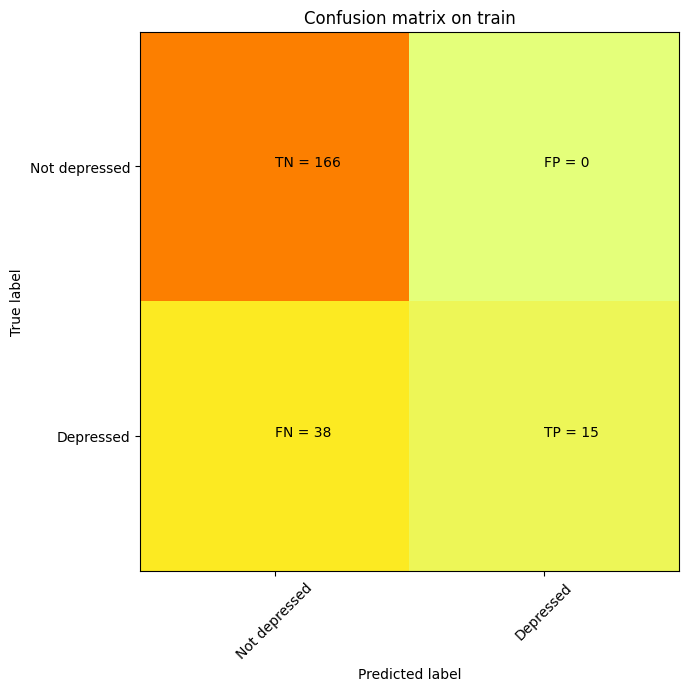

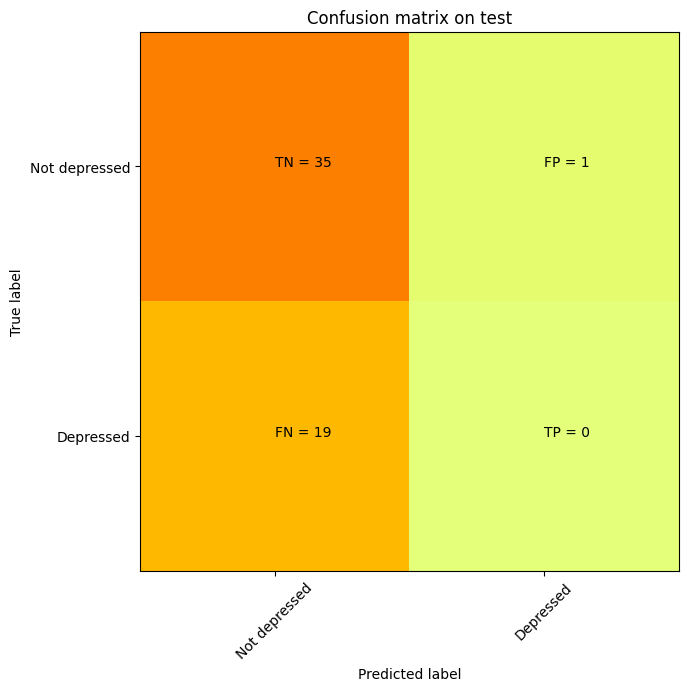

In [37]:
# Plot confusion matrix
l_classe_names = ['Not depressed', 'Depressed']
plot_confusion_matrix(d_train_eval['cm'], l_classe_names, "Confusion matrix on train", show_value=True)
plot_confusion_matrix(d_test_eval['cm'], l_classe_names, "Confusion matrix on test", show_value=True)

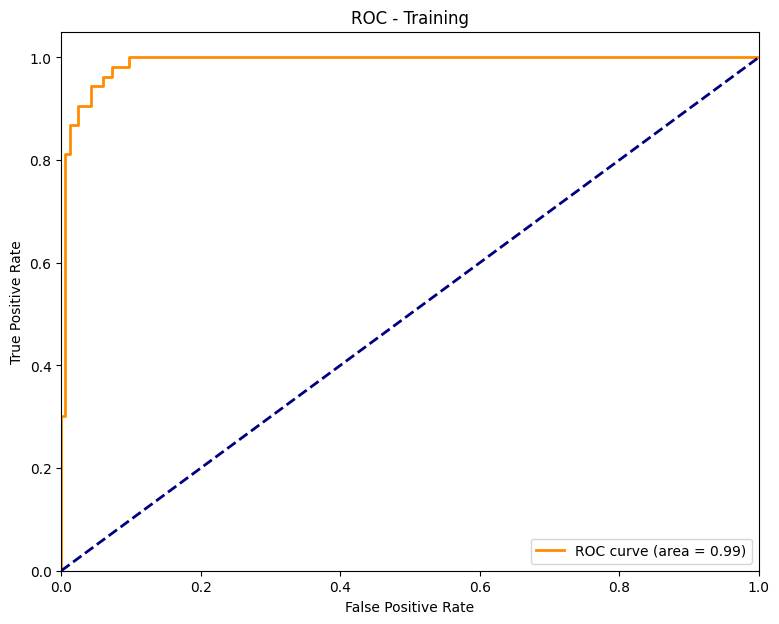

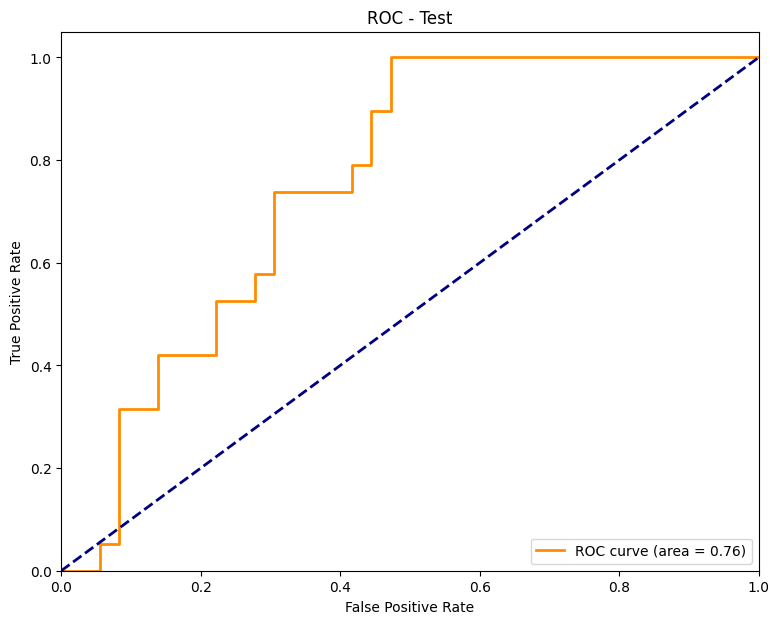

In [38]:
# Plot ROCs
fpr, tpr, roc_auc = d_train_eval['roc_auc']['fpr'], d_train_eval['roc_auc']['tpr'], \
    d_train_eval['roc_auc']['roc_auc']
plot_roc_auc(fpr, tpr, roc_auc, "ROC - Training")

fpr, tpr, roc_auc = d_test_eval['roc_auc']['fpr'], d_test_eval['roc_auc']['tpr'], \
    d_test_eval['roc_auc']['roc_auc']
plot_roc_auc(fpr, tpr, roc_auc, "ROC - Test")